#################################################
### ** Created by Marcelo Oliveira on 24/06/2021. **
### **Disciplina de Fundametos de IA aplicados ao Diagnóstico de Doenças.**
### ** Copyright (c)2020 Instituto de Computação **
### ** Universidade Federal de Alagoas - UFAL. All rights reserved.**
#################################################

References:

1.   https://asvcode.github.io/MedicalImaging/medical_imaging/dicom/fastai/2020/04/28/Medical-Imaging-Using-Fastai.html
2.   https://towardsdatascience.com/understanding-dicoms-835cd2e57d0b
https://www.kaggle.com/jhoward/
3.   https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai

4. https://www.kaggle.com/jhoward/from-prototyping-to-submission-fastai


### Requerimentos: pydicom, scikit-image, kornia, fastai 


*   pip install pydicom
*   pip install scikit-image
*   pip install kornia
*   pip install git+https://github.com/fastai/fastai.git










In [4]:
pip install pydicom

In [ ]:
pip install scikit-image

In [ ]:
pip install kornia

     |████████████████████████████████| 301 kB 8.9 MB/s 


In [ ]:
pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-_enk59t0
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-_enk59t0
     |████████████████████████████████| 54 kB 2.5 MB/s 
  Created wheel for fastai: filename=fastai-2.4.2-py3-none-any.whl size=186238 sha256=1ddbe8d3ce16bd8d1d90f6bf1398a3fe01fec87bf23a183a8e014b96dec773a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-u3xvwi64/wheels/e2/81/30/9d0af3c5b8212ceb1118de039a8973c37f047102062f346d19
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastai
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.data.all import *
from fastai.vision.models import *

import pydicom,kornia,skimage



Em nosso exemplo vamos usar a base do  SIIM-ACR Pneumothorax Segmentation dataset com (250 arquivos DICOM files - 30MB)
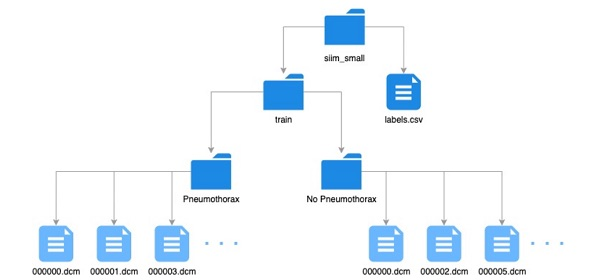

In [ ]:
#Load the Data
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

# Patching
**Função get_dicom_files**
Carrega de maneira recursiva imagens .dcm a partir de um folder(diretório);

In [ ]:
items = get_dicom_files(pneumothorax_source, recurse=True, folders='train')
print("O numero de exames é..:", len(items))
print("Path Imagens do Paciente 240..:",items[240])

O numero de exames é..: 250
Path Imagens do Paciente 240..: /root/.fastai/data/siim_small/train/No Pneumothorax/000033.dcm


# Leitura do arquivo DCM
Pydicom converte o DICOM numa estrutura pythonic para facilitar a sua manipulação

In [ ]:
dimg = pydicom.dcmread(items[100])
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2372.1517875172.409638
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2372.1517875172.409638
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

Pydicom lê os pixels da imagem como **raw bytes** por padrão (PixelData). Atenção: as imagens armazenadas no DICOM podem variar a depender do equipamento, ex.:
*   Pixels podem ser amazenados como float, signed e unsigned integers;
*   Ordem dos pixels pode ser invertida (little endian big endian);




In [ ]:
dimg.PixelData[:100]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\x0e<\x02\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00'

Ao inves de tentar entender o hexa do Raw do DICOM, podemos visualzar melhor os valores dos Pixels usando um array contendo os dados de cada pixel:
dimg.pixel_array irá retornar um numpy.ndarray

In [ ]:
dimg.pixel_array, dimg.pixel_array.shape

(array([[23, 21, 19, ..., 92, 93, 55],
        [18, 16, 14, ..., 72, 72, 37],
        [14, 13, 11, ..., 59, 58, 27],
        ...,
        [14, 14, 13, ..., 36, 33, 15],
        [16, 15, 15, ..., 38, 35, 16],
        [17, 17, 16, ..., 40, 36, 17]], dtype=uint8), (1024, 1024))

Transformando o array em Tensor

In [ ]:
ten_img = TensorDicom(dimg.pixel_array)
ten_img

TensorDicom([[23, 21, 19,  ..., 92, 93, 55],
        [18, 16, 14,  ..., 72, 72, 37],
        [14, 13, 11,  ..., 59, 58, 27],
        ...,
        [14, 14, 13,  ..., 36, 33, 15],
        [16, 15, 15,  ..., 38, 35, 16],
        [17, 17, 16,  ..., 40, 36, 17]], dtype=torch.uint8)

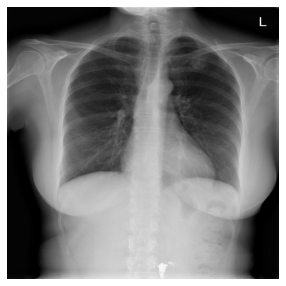

In [ ]:
ten_img.show()

TensorDICOM possui uma função para ajustar o brilho e contraste para "osso"

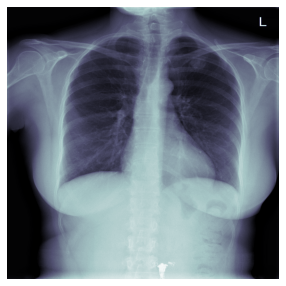

In [ ]:
ten_img = TensorDicom(dimg.pixel_array)
ten_img.show(cmap=plt.cm.bone)

Que tal um "Rainbow Colormap" ?

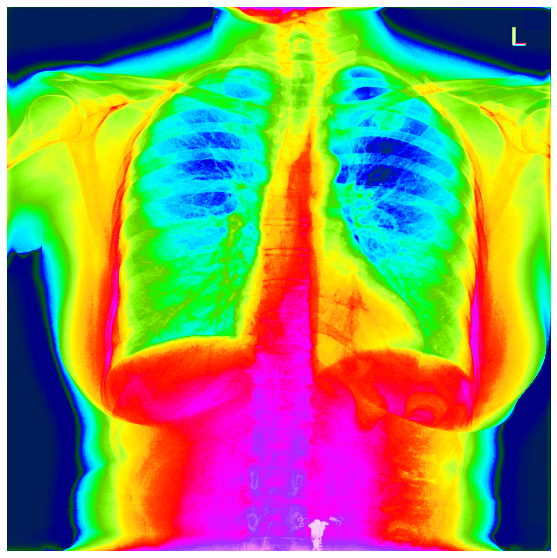

In [ ]:
ten_img.show(cmap=plt.cm.gist_ncar, figsize=(10,10))

# Janelamento (Windowing)

# Entendendo as Densidades dos Tecidos

Vimos que imagens DICOM de CT com 16 bits podem ter valores de pixels variando entre -32768 a 32768. 

Na imagem abaixo lemos um arquivo DICOM (raw), sem tratamento. 

In [ ]:
dicomImgLocal = Path('/content/drive/My Drive/DataSets/CT_aulaDICOM/2')
dicomItems = get_dicom_files(dicomImgLocal) 
dicom16bits = pydicom.dcmread(dicomItems[3])
#(0028, 0100) Bits Allocated
dicom16bits
#dicom16bits.show()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 184
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.1.111.2724.1506707662.14697
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.360.0.3.5.4
(0002, 0013) Implementation Version Name         SH: 'IIS_354'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0012) Instance Creation Date              DA: '20170929'
(0008, 0013) Instance Creation Time              TM: '145422'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.1.111.2724.1506707662.14

# Convertendo um array de Pixel para um Tensor.

# DICOM
Rescale Slope e Rescale Intercept permitem manipular os valores dos pixels para HU 

# rescaled pixel = (pixel * RescaleSlope) + RescaleIntercept


In [ ]:
tensor_dicom = TensorDicom(dicom16bits.pixel_array) #convert into tensor
print(f'RescaleIntercept: {dicom16bits.RescaleIntercept:1f}\nRescaleSlope: {dicom16bits.RescaleSlope:1f}\nMax pixel: '
      f'{tensor_dicom.max()}\nMin pixel: {tensor_dicom.min()}\nShape: {tensor_dicom.shape}')

RescaleIntercept: -1024.000000
RescaleSlope: 1.000000
Max pixel: 2373.0
Min pixel: 0.0
Shape: torch.Size([512, 512])


# Plotar o Histograma
Exemplos de HU


*   Ar: -1000 HU
*   Agua: 0 HU
*   Quanto mais denso o tecido maior o HU, Osso: 2000 HU



(array([2.14714e+05, 2.96500e+03, 1.97600e+03, 3.59600e+03, 3.59830e+04,
        2.31300e+03, 4.00000e+02, 1.07000e+02, 5.00000e+01, 4.00000e+01]),
 array([   0. ,  237.3,  474.6,  711.9,  949.2, 1186.5, 1423.8, 1661.1,
        1898.4, 2135.7, 2373. ], dtype=float32),
 <a list of 10 Patch objects>)

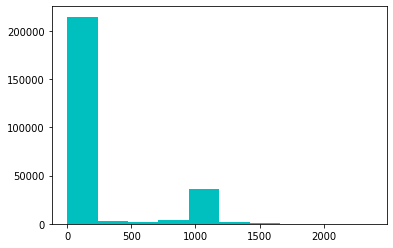

In [ ]:
#px = dicom16bits.pixels.flatten()
px = dicom16bits.pixels
#plt.hist(px, color='c')
plt.hist(px.flatten(), color='c')

Explicao de uma das duvidas da última aula: 
The histogram above shows that the bulk of the pixels are distributed around 0 and 1000 which does not correctly represent the tissues densities in the image.

This why RescaleSlope and RescaleIntercept are important and scaled_px uses these values to correctly scale the image so that they represent the correct tissue densities.

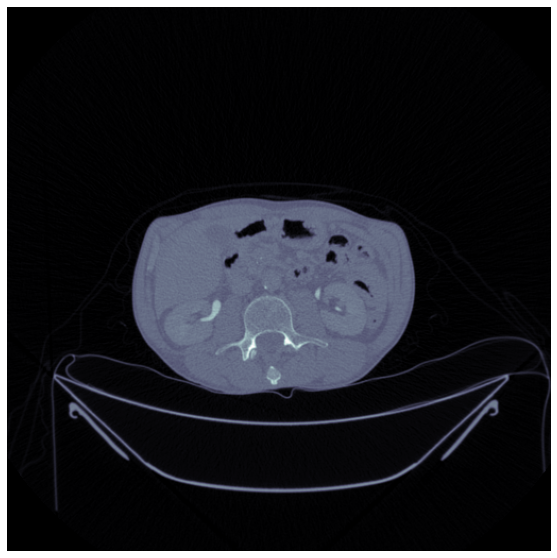

In [ ]:
p = dicom16bits.pixels
re = (p * dicom16bits.RescaleSlope + dicom16bits.RescaleIntercept)
show_image(re, cmap='bone', figsize=(10,10));

(array([2.14714e+05, 2.96500e+03, 1.97600e+03, 3.59600e+03, 3.59830e+04,
        2.31300e+03, 4.00000e+02, 1.07000e+02, 5.00000e+01, 4.00000e+01]),
 array([-1024. ,  -786.7,  -549.4,  -312.1,   -74.8,   162.5,   399.8,
          637.1,   874.4,  1111.7,  1349. ], dtype=float32),
 <a list of 10 Patch objects>)

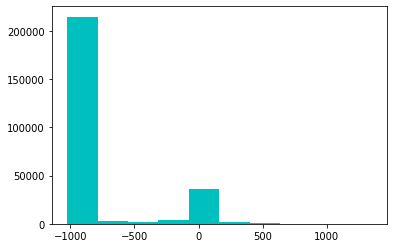

In [ ]:
plt.hist(re.flatten(), color='c')

# Windowing

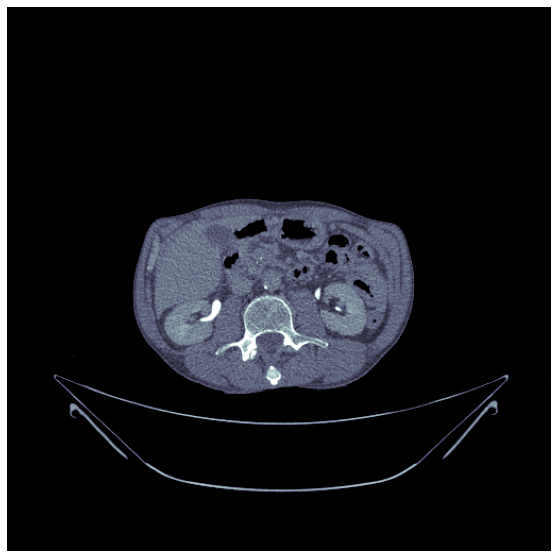

In [ ]:
peu = re.windowed(l=100, w=700)
show_image(peu, cmap='bone', figsize=(10,10));

(array([2.20607e+05, 8.97000e+02, 4.50500e+03, 9.85200e+03, 1.78760e+04,
        5.74600e+03, 1.23500e+03, 5.77000e+02, 2.05000e+02, 6.44000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

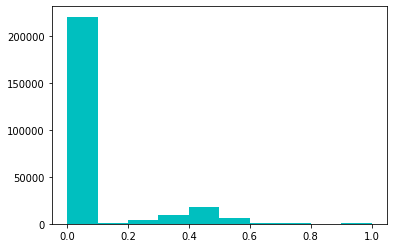

In [ ]:
plt.hist(peu.flatten(), color='c')

Atenção ao valores normalizados

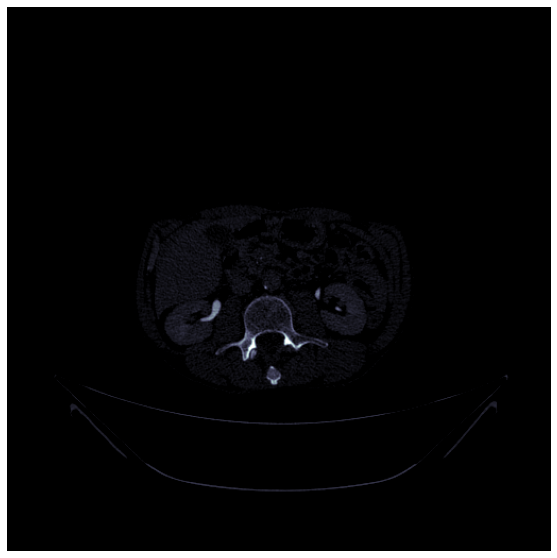

In [ ]:
peu2 = re.windowed(l=600, w=1200)
show_image(peu2, cmap='bone', figsize=(10,10));

(array([2.56362e+05, 4.35600e+03, 7.35000e+02, 2.49000e+02, 1.88000e+02,
        1.19000e+02, 3.90000e+01, 2.70000e+01, 2.30000e+01, 4.60000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

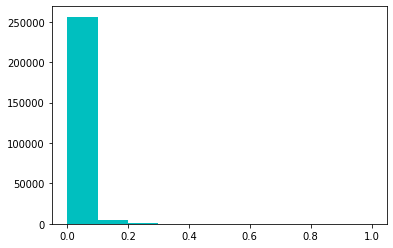

In [ ]:
plt.hist(peu2.flatten(), color='c')

# FastAI Tabela de Janelamento 
Window/Level (dicom_windows)
* brain=(80,40),
* subdural=(254,100),
* stroke=(8,32),
* brain_bone=(2800,600),
* brain_soft=(375,40),
* lungs=(1500,-600),
* mediastinum=(350,50),
* abdomen_soft=(400,50),
* liver=(150,30),
* spine_soft=(250,50),
* spine_bone=(1800,400)












In [ ]:
dicom_windows = types.SimpleNamespace(
    test_window=(1800,400),
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400)
)


**Carregar todos os cortes da  Base local Fribose** 

In [ ]:
csource = Path('/content/drive/My Drive/DataSets/Fibrosis')
citems = get_dicom_files(csource)
print("O numero de exames é..:", len(citems))

O numero de exames é..: 436


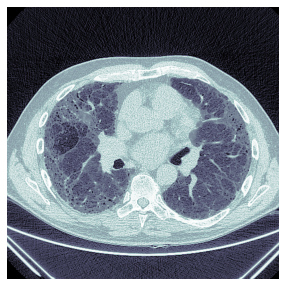

In [ ]:
imgDICOM = citems[100]
patient2 = pydicom.dcmread(imgDICOM)
patient2.show()

# Exemplo de Janelamento arbitrário

In [ ]:
imgDICOM = citems[100]
dimg2 = pydicom.dcmread(imgDICOM)

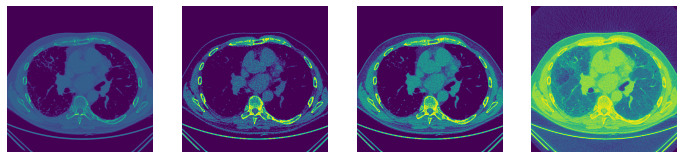

In [ ]:
show_images(dimg2.to_nchan([dicom_windows.test_window,dicom_windows.subdural,dicom_windows.abdomen_soft]))

# Janela Pulmão

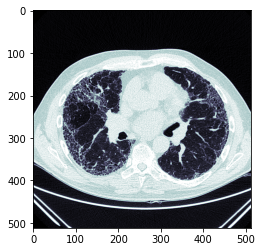

In [ ]:
plt.imshow(patient2.windowed(w=1500, l=-600), cmap=plt.cm.bone)

# Janela óssea

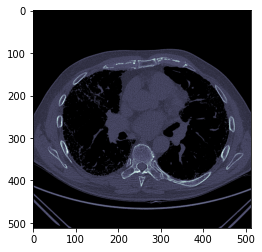

In [ ]:
plt.imshow(patient2.windowed(w=1800, l=400), cmap=plt.cm.bone)

Converter o DICOM em Tensors para manipulá-lo

TensorDicom([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

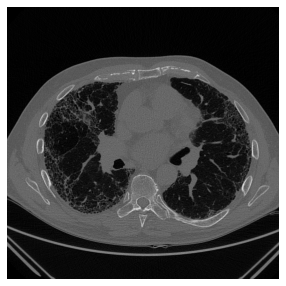

In [ ]:
#class TensorDicom(TensorImage): _show_args = {'cmap':'bone'}
tensor_dicom = TensorDicom(dimg2.pixel_array)
tensor_dicom.show()
tensor_dicom

Visualizar uma ROI (region of interest)

In [ ]:
portion = tensor(tensor_dicom)[100:256,100:256]
portion.shape

torch.Size([156, 156])

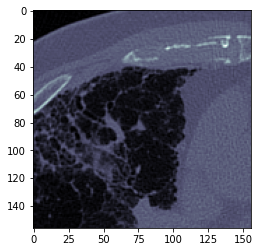

In [ ]:
plt.imshow(portion, cmap=plt.cm.bone)

# Salvar um Tensor em .jpg com um determinada Janela

In [ ]:
dimg2.save_jpg(path=(pneumothorax_source/f'train/01dicom.jpg'), wins=[dicom_windows.lungs, dicom_windows.lungs])

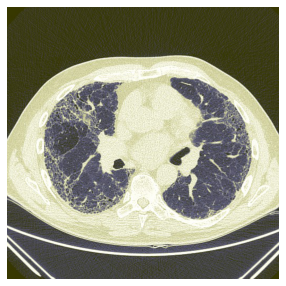

In [ ]:
show_image(Image.open(pneumothorax_source/f'train/01dicom.jpg'))